In [2]:

#lung disease prediction by shrey sharma 219311186
 
import numpy as np
import pickle
import cv2
import os
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import regularizers

In [3]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 1000

# Path to the dataset folder
root_dir = r"Lung X-Ray Image\Lung X-Ray Image"

train_dir = r"Lung X-Ray Image\Lung X-Ray Image"


In [4]:
EPOCHS = 100
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

In [5]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image,DEFAULT_IMAGE_SIZE )   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Lung_Opacity ...
[INFO] Processing Normal ...
[INFO] Processing Viral Pneumonia ...
[INFO] Image loading completed

Total number of images: 3000


In [7]:
label_list

['Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity',
 'Lung_Opacity

In [8]:
image_size = len(image_list)
image_size


3000

In [11]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)


In [12]:
print(label_binarizer.classes_)

['Lung_Opacity' 'Normal' 'Viral Pneumonia']


In [13]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 


[INFO] Spliting data to train, test


In [14]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [15]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))


In [16]:
model.compile(optimizer="Adam",loss="binary_crossentropy",metrics=["accuracy"])

In [17]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=5, verbose=1
    )

C:\Users\Shrey\AppData\Local\Temp\ipykernel_12836\1308405557.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5


75/75 [==============================] - 390s 5s/step - loss: 0.5668 - accuracy: 0.7229 - val_loss: 5.0991 - val_accuracy: 0.6117
Epoch 2/5
75/75 [==============================] - 681s 9s/step - loss: 0.4222 - accuracy: 0.7646 - val_loss: 9.5706 - val_accuracy: 0.3617
Epoch 3/5
75/75 [==============================] - 196s 3s/step - loss: 0.3694 - accuracy: 0.7858 - val_loss: 10.4135 - val_accuracy: 0.3617
Epoch 4/5
75/75 [==============================] - 202s 3s/step - loss: 0.3906 - accuracy: 0.7642 - val_loss: 1.1963 - val_accuracy: 0.5733
Epoch 5/5
75/75 [==============================] - 201s 3s/step - loss: 0.3747 - accuracy: 0.7842 - val_loss: 0.6333 - val_accuracy: 0.6550


In [14]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy

19/19 [==============================] - 12s 516ms/step - loss: 0.2795 - accuracy: 0.8283
Test Accuracy: 82.833331823349


In [24]:
print(len(model.layers))

20


In [23]:
model.save(r'Lung X-Ray Image')

INFO:tensorflow:Assets written to: Lung X-Ray Image\assets


INFO:tensorflow:Assets written to: Lung X-Ray Image\assets


In [20]:
predictions=[]

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [11]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = np.argmax(model.predict(np_image))
    return result

1/1 [==============================] - 0s 59ms/step
Viral Pneumonia


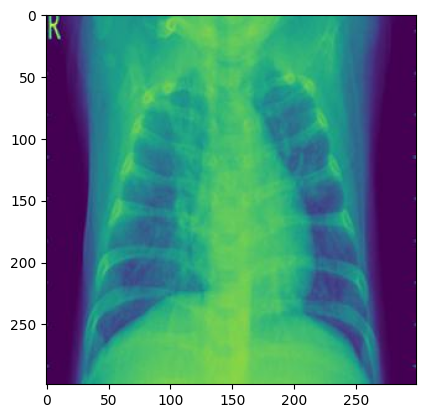

In [23]:
res=predict_disease(r"Lung X-Ray Image\Lung X-Ray Image\Viral Pneumonia\996.jpg")
print(label_binarizer.classes_[res])

1/1 [==============================] - 0s 46ms/step
Normal


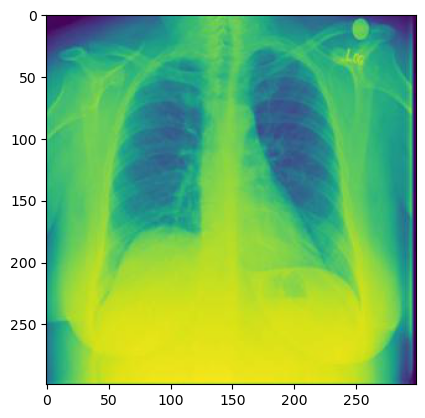

In [46]:
res=predict_disease(r"Lung X-Ray Image\Lung X-Ray Image\Normal\984.jpg")
print(label_binarizer.classes_[res])

1/1 [==============================] - 0s 65ms/step
Lung_Opacity


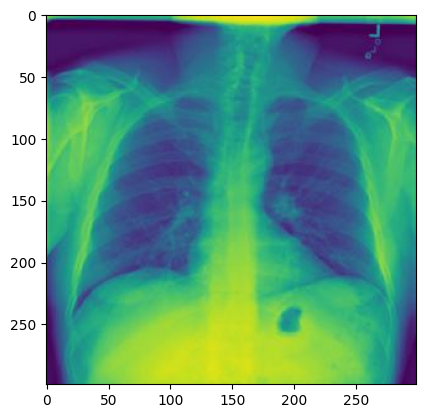

In [22]:
res=predict_disease(r"Lung X-Ray Image\Lung X-Ray Image\Lung_Opacity\90.jpg")
print(label_binarizer.classes_[res])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 activation_7 (Activation)   (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_6 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 85, 85, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 85, 85, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 85, 85, 64)       

In [9]:
model = tf.keras.models.load_model(r"Lung X-Ray Image")

In [32]:
predtest=[]
predtest=model.predict(x_test)

19/19 [==============================] - 4s 185ms/step


In [33]:
predictions1=[0]*len(predtest)
cnt=0

In [34]:
for i in range(len(predtest)):
    
    a=np.argmax(predtest[i])
    predictions1[cnt]=a
    cnt+=1



In [35]:
predictions1

[1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 0,
 2,
 2,
 0,
 1,
 0,
 2,
 0,
 1,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 1,
 0,
 1,
 1,
 1,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 0,
 2,
 0,
 2,
 1,
 1,
 2,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 0,
 1,
 2,
 0,
 2,
 1,
 2,
 2,
 0,
 1,
 2,
 1,
 1,
 0,
 2,
 2,
 0,
 1,
 2,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 2,
 2,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 0,
 0,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 0,
 2,
 1,
 2,
 0,
 2,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 2,
 0,
 0,
 1,
 1,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 2,
 0,
 2,
 1,
 0,
 1,
 1,
 2,
 0,
 1,


In [36]:
truevals=[0]*len(predtest)
cnt=0

In [37]:
for i in range(len(y_test)):
    
    a=np.argmax(y_test[i])
    truevals[cnt]=a
    cnt+=1

In [38]:
truevals

[1,
 1,
 1,
 0,
 2,
 1,
 1,
 2,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 0,
 1,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 1,
 0,
 1,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 2,
 0,
 2,
 0,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 1,
 0,
 1,
 2,
 0,
 2,
 1,
 2,
 2,
 0,
 1,
 2,
 1,
 1,
 0,
 2,
 2,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 2,
 1,
 2,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 2,
 2,
 0,
 2,
 2,
 1,
 0,
 2,
 1,
 2,
 1,
 0,
 1,
 0,
 2,
 1,
 2,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 0,
 2,
 0,
 0,
 1,
 1,
 0,
 2,
 1,
 1,
 2,
 2,
 0,
 2,
 2,
 1,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 1,
 1,
 2,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 2,
 0,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 2,


In [39]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [40]:
report = classification_report(truevals, predictions1)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.64      0.75       217
           1       0.78      0.89      0.83       197
           2       0.82      0.98      0.89       186

    accuracy                           0.83       600
   macro avg       0.84      0.84      0.83       600
weighted avg       0.84      0.83      0.82       600



[[139  47  31]
 [ 13 176   8]
 [  1   3 182]]


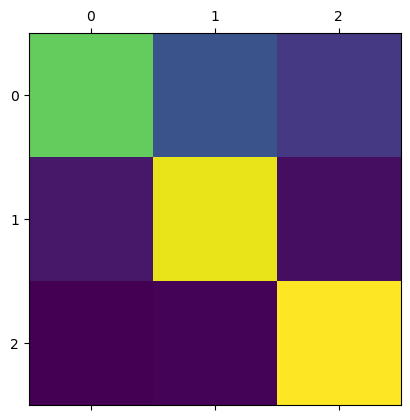

In [41]:
cm=confusion_matrix(truevals,predictions1)
print(cm)
plt.matshow(cm)

<Axes: >

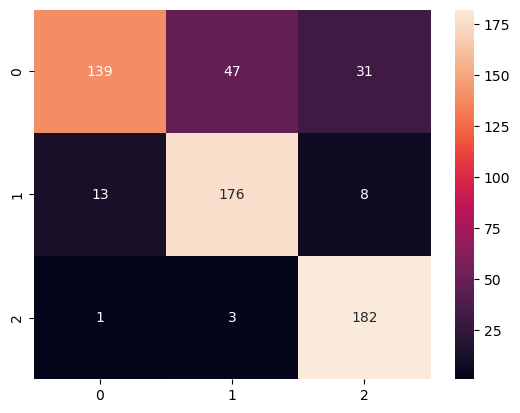

In [42]:
import seaborn as sn
sn.heatmap(cm,annot=True,fmt='g')

In [43]:
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)



In [44]:
print("TPR:",TPR)
print("TNR:",TNR)
print("PPV:",PPV)
print("NPV:",NPV)
print("FPR:",FPR)
print("FNR:",FNR)
print("FDR:",FDR)

TPR: [0.640553   0.89340102 0.97849462]
TNR: [0.96344648 0.87593052 0.9057971 ]
PPV: [0.90849673 0.77876106 0.82352941]
NPV: [0.82550336 0.94385027 0.98944591]
FPR: [0.03655352 0.12406948 0.0942029 ]
FNR: [0.359447   0.10659898 0.02150538]
FDR: [0.09150327 0.22123894 0.17647059]
